In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML
from types import SimpleNamespace

# Decomposing Polygonal into Grids

My thesis requires a path planning component. In this notebook I will try to implement the initial ideas.

Consider a polygon with $n$ vertices.
$$
\text{polygon} = \begin{bmatrix}
x^0 & y^0 \\
x^1 & y^1 \\
x^3 & y^2 \\
\vdots  & \vdots \\
x^{n-1} & y^{n-1} \\
\end{bmatrix}$$

The vertices are arranged counter-clockwise.

In [2]:
polygon = np.array([[-2, -4], [ -4, -5], [-3, -7], [5, -3], [8, 4], [-1, 6]])

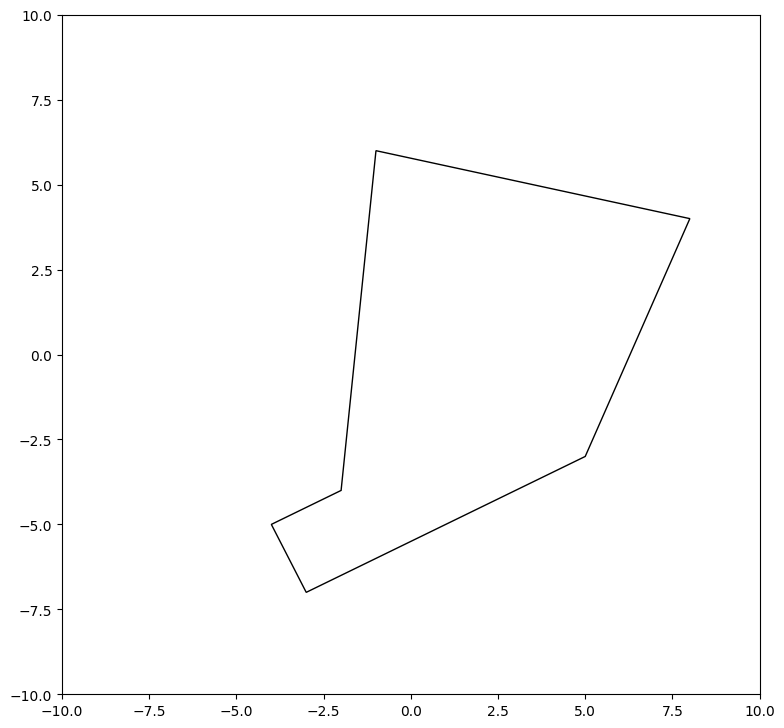

In [3]:
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(9, 9)
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))
polygonShape = plt.Polygon(polygon, fill=None)
ax.add_patch(polygonShape)
plt.show() 


To find the bounding box of the polygon, we need to find the vertices

$$
\text{boundingBox} = \begin{bmatrix}
x_{min} & y_{min} \\
x_{max} & y_{min} \\
x_{max} & y_{max} \\
x_{min} & y_{max}
\end{bmatrix}
$$

Where each row defines vertex.

In [4]:
def getMinMaxVertices(polygon):
  (xMax, yMax) = np.max(polygon, axis = 0)
  (xMin, yMin) = np.min(polygon, axis = 0)
  return (xMin, yMin, xMax, yMax) 

def getBoundingBoxVertices(polygon):
  (xMin, yMin, xMax, yMax) = getMinMaxVertices(polygon)
  return np.array(((xMin, yMin), (xMax, yMin), (xMax, yMax), (xMin, yMax)))

boundingBox = getBoundingBoxVertices(polygon)

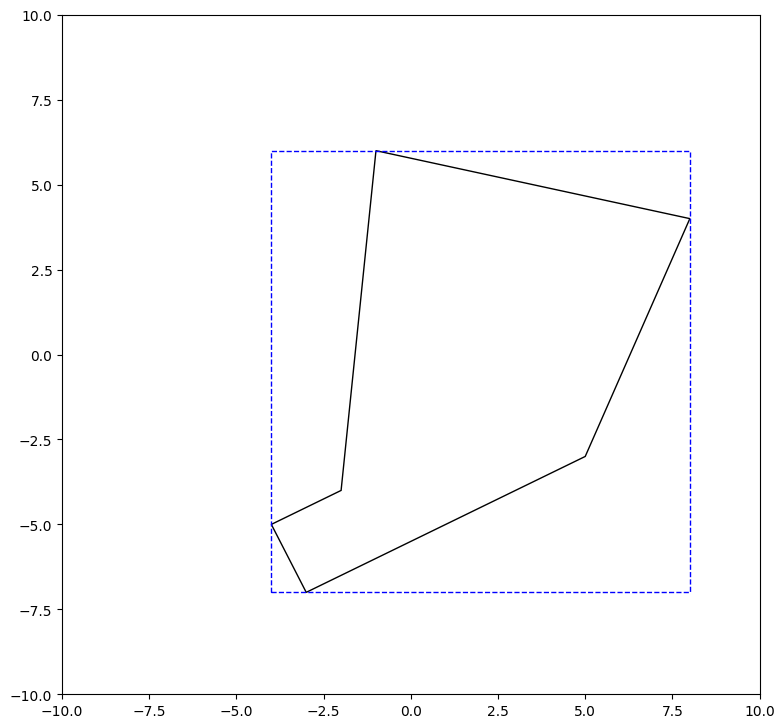

In [5]:
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(9, 9)
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))
polygonShape = plt.Polygon(polygon, fill=None)
boundingBoxShape = plt.Polygon(boundingBox, fill=None, edgecolor='b', ls='--')

ax.add_patch(polygonShape)
ax.add_patch(boundingBoxShape)
plt.show() 


Lets take a grid with each square of cell size $c$.

We can take set $c$ either depending on the number of cells we want.

$$c = \text{BoundingBox}_{width|heigh} \div  n $$

Or set a fixed size for each cell. 

For our purpose we will take a fixed cell size.

In [6]:
c = 1

We will calculate the coordinate $(b^{i,j}_x, b^{i,j}_y)$ of bottom left vertex of each cell.

$$\text{cells} =\begin{bmatrix}
b^{0,0}_x & b^{0,0}_y \\
b^{1,0}_x & b^{1,0}_y \\
b^{2,0}_x & b^{2,0}_y \\
\vdots & \vdots \\
b^{i_{max} - 1,0}_x & b^{i_{max} - 1,0}_y \\
b^{0,1}_x & b^{0,1}_y \\
b^{1,1}_x & b^{1,1}_y \\
b^{2,1}_x & b^{2,1}_y \\
\vdots & \vdots \\
b^{i_{max} - 1,0}_x & b^{i_{max} - 1,0}_y \\
\vdots & \vdots \\
b^{i_{max} - 1,j_{max}-1}_x & b^{i_{max} - 1,j_{max} - 1}_y \\
\end{bmatrix}$$

$$
b^{i,j}_x = x_{min} + i * c \\
b^{i,j}_y = y_{min} + j * c
$$

$i$, $j$ are the index in $x$  and $y$ axis respectively.


We can get the range of $i$ and $j$ by
$$
i_{max} = \left\lceil\frac{x_{max} - x_{min}}{c}\right\rceil \\
j_{max} = \left\lceil\frac{y_{max} - y_{min}}{c}\right\rceil \\
$$

Let number of vertices in *gridCells* be $k$ and $$ k = i_{max} \times j_{max}$$


We need to calculate grid index $(i,j)$ from $k$ 

$$
j = \left\lfloor\frac{k}{i_{max}}\right\rfloor \\
i = k  - j \times i_{max}
$$

In [7]:
def getGridRange(xMin, yMin, xMax, yMax, cellSize):
  iMax = math.ceil((xMax - xMin)/cellSize)
  jMax = math.ceil((yMax - yMin)/cellSize)
  return (iMax, jMax)

def getGridCells(iMax, jMax, xMin, yMin, cellSize):
  totalGrids = iMax * jMax
  grids =  np.zeros((totalGrids, 2))
  ctr = 0
  for j in range (jMax):
    for i in range(iMax):
      grids[ctr, 0] = xMin + i * cellSize
      grids[ctr, 1] = yMin + j * cellSize
      ctr += 1
  return grids

def getGridCellIndex(iMax, jMax, k):
  j = math.floor(k/iMax)
  i = k - j * iMax
  return (i, j)

# namespace to hold grid related methods and variables
GridCells = SimpleNamespace()

GridCells.minMax = getGridRange(*getMinMaxVertices(polygon), c)

GridCells.cells = getGridCells(*GridCells.minMax, *getMinMaxVertices(polygon)[0:2],  c)

GridCells.getIndex = getGridCellIndex

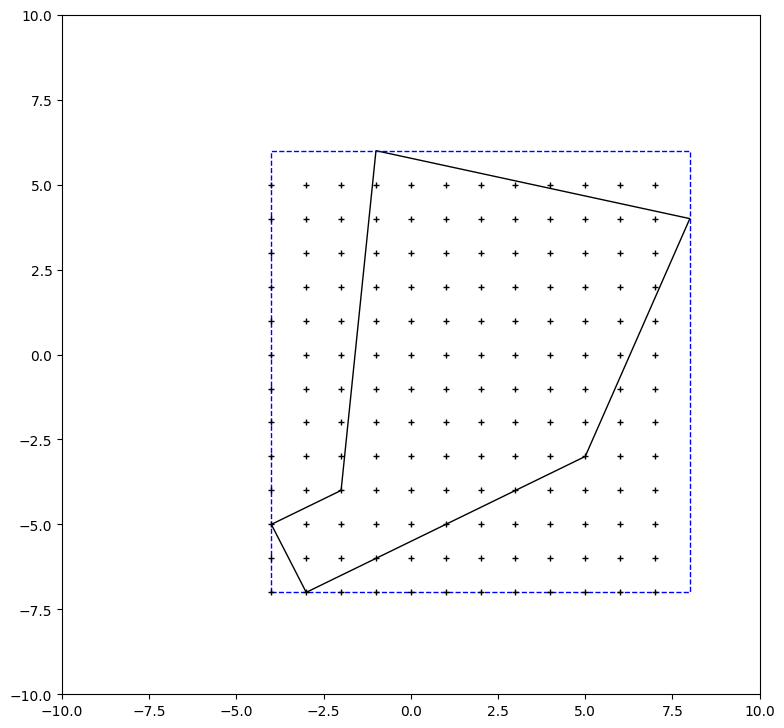

In [8]:
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(9, 9)
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))

polygonShape = plt.Polygon(polygon, fill=None)

boundingBoxShape = plt.Polygon(boundingBox, fill=None, edgecolor='b', ls='--')

plt.plot(*zip(*GridCells.cells), marker='+', ms=5, color='k', ls='')

ax.add_patch(polygonShape)
ax.add_patch(boundingBoxShape)
plt.show() 


Since the vertex $v$ of the polygon is arranged counter clockwise, we can easily get the vertices of line segment for each side of the polygon.

$$v_i = (x_i, y_i) \\
s < n$$

$$\text{polygonLineSegments}=\begin{bmatrix}
v_0 & v_1 \\
v_1 & v_2 \\
\vdots & \vdots \\
v_s & v_{s+1} \\
\vdots & \vdots \\
v_{s_{max}-1} & s_0 \\
\end{bmatrix}$$

$$=\begin{bmatrix}
x_0 & y_0 & x_1 & y_1 \\
x_1 & y_1 & x_2 & y_2\\
\vdots && \vdots \\
x_s & y_s & x_{s+1} & y_{s+1} \\
\vdots && \vdots \\
x_{n-1} & y_{n-1} & x_{0} & y_{0} \\
\end{bmatrix}$$


In [9]:
def getLineSegments(polygon):
  n = np.shape(polygon)[0]
  lines = np.zeros((n, 4))
  for s in range(n):
    if s != (n - 1):
      lines[s, 0] = polygon[s, 0]
      lines[s, 1] = polygon[s, 1]
      lines[s, 2] = polygon[s + 1, 0]
      lines[s, 3] = polygon[s + 1, 1]
    else:
      lines[s, 0] = polygon[s, 0]
      lines[s, 1] = polygon[s, 1]
      lines[s, 2] = polygon[0, 0]
      lines[s, 3] = polygon[0, 1]

  return lines

We can imagine the center of each grid cell is pojecting a line parallel to $x$ axis till $x_{max} + 1$.

$$
\text{cellCenter} = [\text{cells}] +  \frac{c}{2} \\
\text{rays} = \begin{bmatrix}
\text{cellCenter}_x^{0,0} & \text{cellCenter}_y^{0,1} & x_{max} + 1 & \text{cellCenter}_y^{0,1} \\
\text{cellCenter}_x^{1,0} & \text{cellCenter}_y^{1,1} & x_{max} + 1 & \text{cellCenter}_y^{1,1} \\
\text{cellCenter}_x^{2,0} & \text{cellCenter}_y^{2,1} & x_{max} + 1 & \text{cellCenter}_y^{2,1} \\
\vdots && \vdots \\
\text{cellCenter}_x^{k-1,0} & \text{cellCenter}_y^{k-1,1} & x_{max} + 1 & \text{cellCenter}_y^{k-1,1} \\
\end{bmatrix}
$$

In [10]:
GridCells.cellsCenter = GridCells.cells + c/2 

def getGridRays(cellsCenter, xMax):
  k = np.shape(cellsCenter)[0]
  gridRays = np.zeros((k, 4))
  gridRays[:, 0:2] = cellsCenter
  gridRays[:, 2] = xMax + 1
  gridRays[:, 3] = cellsCenter[:,1]
  return gridRays

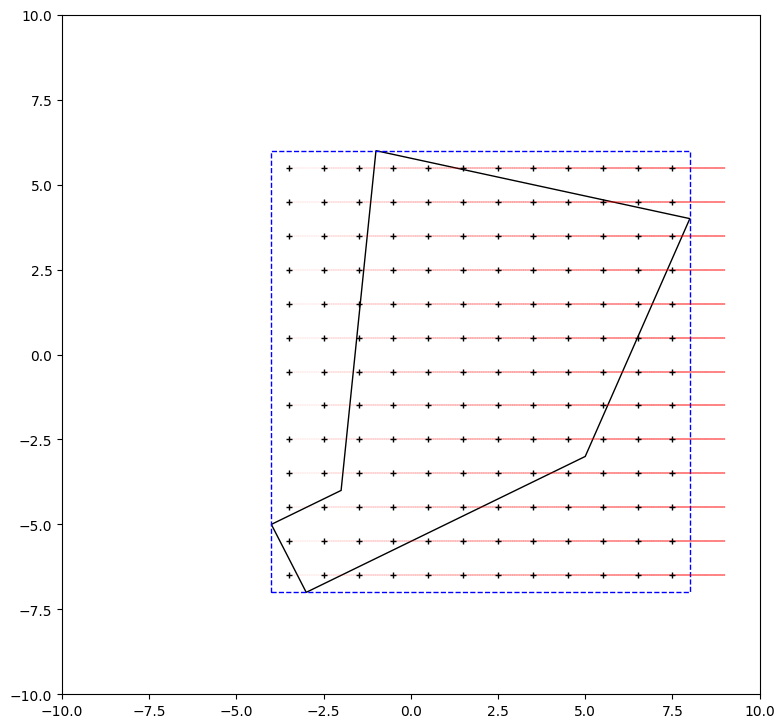

In [11]:
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(9, 9)
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))

polygonShape = plt.Polygon(polygon, fill=None)

boundingBoxShape = plt.Polygon(boundingBox, fill=None, edgecolor='b', ls='--')

def plotRays(rays):
  for i in range(np.shape(rays)[0]):
    line = plt.Line2D((rays[i,0], rays[i,2]),
                      (rays[i,1], rays[i,3]),
                      ls='--', color='r', lw=0.3, alpha=0.3,
                      dash_capstyle='round')
    ax.add_line(line);

plotRays(getGridRays(GridCells.cellsCenter, getMinMaxVertices(polygon)[2]))
ax.add_patch(polygonShape)
ax.add_patch(boundingBoxShape)
plt.plot(*zip(*GridCells.cellsCenter), marker='+', ms=5, color='k', ls='')
plt.show() 


Now we will apply **ray tracing** to check if $cell^{i,j}$ is inside our polygon or not. We will count how many intersections each $rays^{i,j}$ makes with all the lines in *polygonLineSegments*. If the number of intersections are even then the *cell* is outside the polygon. If the number of intersections are odd, then the *cell* is inside the polygon.

The algorithm for checking intersection of line segments has been inspired from https://www.codeproject.com/Tips/862988/Find-the-Intersection-Point-of-Two-Line-Segments.


In [12]:
def isIntersecting(lineSegment, otherLineSegments):
  n = np.shape(otherLineSegments)[0]
  lineSegments = np.full((n, 4), lineSegment)

  f = lineSegments[:, 2:4] - lineSegments[:, 0:2]
  g = otherLineSegments[:, 2:4] - otherLineSegments[:, 0:2]
  qmp = otherLineSegments[:, 0:2] - lineSegments[:, 0:2]
  
  fxg = np.cross(f, g)
  qpxf = np.cross(qmp, f)

  mantessa = 1e-10

  # collinear but disjoint
  isCollinear = np.logical_and(
    np.abs(fxg) <= mantessa,
    np.abs(qpxf) <= mantessa
  )

  f = f[np.logical_not(isCollinear)]
  g = g[np.logical_not(isCollinear)]
  qmp = qmp[np.logical_not(isCollinear)]
  fxg = fxg[np.logical_not(isCollinear)]
  qpxf = qpxf[np.logical_not(isCollinear)]

  # parallel and non intersecting
  isParallel = np.logical_and(
    np.abs(fxg) <= mantessa,
    np.abs(qpxf) > mantessa
  )

  f = f[np.logical_not(isParallel)]
  g = g[np.logical_not(isParallel)]
  qmp = qmp[np.logical_not(isParallel)]
  fxg = fxg[np.logical_not(isParallel)]
  qpxf = qpxf[np.logical_not(isParallel)]


  t = np.cross(qmp, g) / fxg
  u = np.cross(qmp, f) / fxg

  return np.logical_and(
      np.abs(fxg) >= mantessa,
      np.logical_and(
          np.logical_and(0 <= t, t <= 1),
          np.logical_and(0 <= u, u <= 1)
      )
  )

def checkLieInside(ray, polygonLineSegments):
  numIntersections = np.sum(isIntersecting(ray, polygonLineSegments))

  if numIntersections == 0 or numIntersections % 2 == 0:
    return False
  else:
    return True

def getInsideGridIndex(rays, polygonLineSegments):
  k = np.shape(rays)[0]
  flag = np.zeros((k), dtype=bool)
  for i in range(k):
    flag[i] = checkLieInside(rays[i], polygonLineSegments)
  return flag

GridCells.valid = getInsideGridIndex(
    getGridRays(GridCells.cellsCenter, getMinMaxVertices(polygon)[2]),
    getLineSegments(polygon))

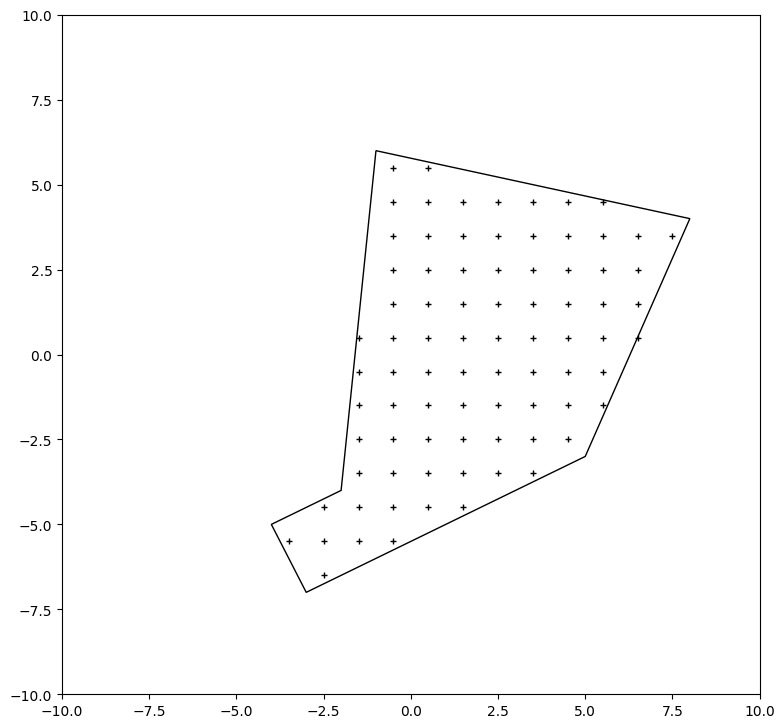

In [13]:
fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(9, 9)
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))

polygonShape = plt.Polygon(polygon, fill=None)



plt.plot(*zip(*GridCells.cellsCenter[GridCells.valid]), marker='+', ms=5, color='k', ls='')

ax.add_patch(polygonShape)
plt.show() 


# Making a navigable Map from Grid Points

Till now we have been able to get the centre of the grid points inside the polygon. We have 3 objects in the global namespace
* polygon
* c
* GridCells
    * ```minMax```
    * ```cells```
    * ```cellsCenter```
    * ```getIndex```


Now we need to make it navigable.

## Cell
   
For that we will create a Grid Cell which encapsulates each cell in the grid.

A *Cell* object has three defining properties.
* Is valid
* Index i.e. $i,j$
* Position i.e. $x,y$

In [14]:
from typing import Tuple, List, Dict

class Cell(object):
  def __init__(self, index: Tuple[int, int], position: Tuple[float, float], valid: bool):
    self.index = index
    self.position = position
    self.valid = valid

  def __str__(self):
    return 'Index %s: Position %s: Valid: %s ' % (self.index, self.position, self.valid)

  def __repr__(self):
    return self.__str__()

## Cell Container
Next we define a CellContainer. A cell container will get contain all the cells and some helper methods to handle the cells.
Its main attriutes are
* ```validCells```
* ```move```, ```moveAndGetCell```
* ```positionToIndex```, ```positionToCell```

Degree of freedom is defined by ```NUM_DIRECTIONS```. It is 8 if diagonal movement is allowed, and 4 if diagonal movements are not allowed.

Throws expection if the movement and position does not honour the bounding box.


In [15]:
class CellContainer(object):
  MOVE = {
      'RIGHT'     : 0,
      'RIGHT-UP'  : 1,
      'UP'        : 2,
      'LEFT-UP'   : 3,
      'LEFT'      : 4,
      'LEFT-DOWN' : 5,
      'DOWN'      : 6,
      'RIGHT-DOWN': 7,
      'STAY'      : 8,
  }

  def __init__(self, boundingBox: Tuple[Tuple[float, float], Tuple[float, float]],
               gridCells: GridCells, cellSize: float, numDirection: int = 4):
    self.iMax, self.jMax = gridCells.minMax
    self.boundingBox = boundingBox
    self.gridCells = gridCells
    self.cellSize = c
    self.validCells = None
    self.fillCells()
    self.NUM_DIRECTIONS = numDirection
    
  def fillCells(self):
    self.cells = [None] * self.iMax;
    self.validCells = []
    for i in range(self.iMax):
      self.cells[i]  = [None] * self.jMax
    for k in range(self.iMax * self.jMax):
      ith, jth = self.gridCells.getIndex(*self.gridCells.minMax, k)
      self.cells[ith][jth] = Cell((ith, jth), 
                                  self.gridCells.cellsCenter[k],
                                  self.gridCells.valid[k])
      if self.gridCells.valid[k]:
        self.validCells.append(self.cells[ith][jth])
    

  def checkValidCell(self, index: Tuple[int ,int ]):
    valid = False
    for cell in self.validCells:
      if cell.index[0] == index[0] and cell.index[1] == index[1]:
        valid = True
    if not valid:
      raise Exception('Invalid grid range %s.' % str(index))

  def checkValidIndex(self, index: Tuple[int, int]):
    if (self.gridCells.minMax[0] <= index[0] or index[0] < 0
        or self.gridCells.minMax[1] <= index[1] or index[1] < 0):
      raise Exception('Out of bounds grid range %s.' % str(index))
      
  def move(self, direction : int, currentIndex : Tuple[int, int]):
    i, j = currentIndex
    newIndexList = [
                (i + 1, j    ),   # RIGHT
                (i + 1, j + 1),   # RIGHT-UP
                (i    , j + 1),   # UP
                (i - 1, j + 1),   # LEFT-UP
                (i - 1, j    ),   # LEFT
                (i - 1, j - 1),   # LEFT-DOWN
                (i    , j - 1),   # DOWN
                (i + 1, j - 1),   # RIGHT-DOWN
                (i    , j    ),   # STAY
    ]

    newIndex = newIndexList[direction * 2 if self.NUM_DIRECTIONS == 4 else direction]
    self.checkValidIndex(newIndex)
    self.checkValidCell(newIndex)
    return newIndex

  def moveAndGetCell(self, direction : int,
                     currentCell: Cell = None,
                     currentIndex: Tuple[int, int] = None):
    if currentCell is None and currentIndex is None:
      raise Exception('Need either cell or currentIndex')

    if currentCell is not None:
      currentIndex = currentCell.index
    i , j = self.move(direction, currentIndex)
    return self.cells[i][j]

  def positionToIndex(self, position: Tuple[int ,int]):
    x, y = position
    i = math.floor((x - self.boundingBox[0, 0]) / self.cellSize) 
    j = math.floor((y - self.boundingBox[0, 1]) / self.cellSize)
    self.checkValidIndex((i, j))
    self.checkValidCell((i, j))
    return (i, j)

  def positionToCell(self, position: Tuple[int, int]):
    i, j = self.positionToIndex(position)
    return self.cells[i][j]

## State

A* search uses the cost function
$$ f = g + h $$

Where $g$ is the total cost till the current state and $h$ is the heurestic cost till the goal state.

In our case a state has multiple agents moving in multiple directions. Let us define $g$ and $h$ for our setup.

$$g = \text{total movement } \forall \text{ agents} \\
h = \text{number of free cells}$$


Therefore, an State will have
* ```movements```, the immediate movements to reach the state
* ```agentCells```, the cells that the agents are occupying in the state
* ```g```
* ```h```
* ```visitedCells```, to compute $h$ for each state

A gobal directory called ```CONSTRAINTS``` is used by State to check constraints
* ```MAX_DISTANCE```
* ```CS_POSITION```, control station $(x,y)$ position

We need to add more constraints, such that an agent can only go upto particular distance away from any other agent.
At least one agent needs to be in range of the control station.

And certain invalid moved that will result in collision.

$$\begin{matrix}
A & B &&&& B & A\\
0 & 0 &&&& 0 & 0
\end{matrix} \\
$$



$$
\begin{matrix}
A & 0 &&&& 0 & B\\
B & 0 &&&& 0 & A
\end{matrix}
$$

In [16]:
class State(object):
  def __init__(self, previousG: float, previousVisitedCells):
    # previousVisitedCells should be i x j np array 
    self.g = previousG
    self.h = 0
    self.visitedCells = np.copy(previousVisitedCells)
    self.movements = {}
    self.agentCells = {}
    self.parent = None

  def addAgentAction(self, agentId: str, movement: int, newCell: Cell):
    if newCell in self.agentCells.values():
      raise Exception('Invalid move, two agents cannot occupy the same node')
    self.movements[agentId] = movement
    self.agentCells[agentId] = newCell

  def f(self):
    return self.g + self.h

  def setParent(self, parent):
    self.parent = parent
    
  def constriant1(self, numDirections: int):
    moved = False
    # At least one agent needs to move
    if 99 in self.movements.values():
      # Initial Condition
      moved = True
    else:
      for movement in self.movements.values():
        if movement < numDirections:
          moved = True
          break 
    if not moved:
      raise Exception('At least one agent needs to move')
      
  def constriant2(self):
    # Check distance between two agents
    maxDistance = CONSTRAINTS['MAX_DISTANCE']
    if len(self.agentCells.values()) == 1:
      return
    for id_l in self.agentCells:
      oneAgentInRange = False
      for id_m in self.agentCells:
        if id_l == id_m:
          continue
        # pythogorims theorem
        x1, y1 = self.agentCells[id_l].position
        x2, y2 = self.agentCells[id_m].position
        xx = x1 - x2
        yy = y1 - y2
        dist = math.sqrt(xx * xx + yy *yy)
        if dist <= maxDistance:
          oneAgentInRange = True
          break
      if not oneAgentInRange:
        raise Exception('Agents cannot leave each others sphere.')
  
  def constriant3(self):
    #check distance of any agent with controlStation
    maxDistance = CONSTRAINTS['MAX_DISTANCE']
    controlStation = CONSTRAINTS['CS_POSITION']
    numAgents = len(self.agentCells.values())

    # At least one agent should be within reach.
    cpos = np.full((numAgents, 2), controlStation[0])
    apos = np.zeros((numAgents, 2))
    
    for i, id_l in enumerate(self.agentCells):
      apos[i] = self.agentCells[id_l].position
      
    dist = np.sqrt(np.sum((cpos-apos) ** 2, axis=1))
    
    if np.min(dist) >= maxDistance:
      raise Exception('At least one agent needs to be in control station range.')


  def constriant4(self, oldState):
    # two agents cannot swap position
    for id_n in self.agentCells:
      for id_m in oldState.agentCells:
        if id_n == id_m:
          continue
        if self.agentCells[id_n] == oldState.agentCells[id_m] and self.agentCells[id_m] == oldState.agentCells[id_n]:
          raise Exception('Agents cannot swap position.')

  def constriant5(self, oldState):
    # two agents should not intersect each others line
    # line equation for paths.
    numAgents = len(self.agentCells.values())
    lineEqs = np.zeros((numAgents, 4))
    for i, id_a in enumerate(self.agentCells):
      lineEqs[i, 0:2] = self.agentCells[id_a].position
      lineEqs[i:,2:4] = oldState.agentCells[id_a].position
      
    for i in range(numAgents):
      eq = lineEqs[i,:]
      otherEqs = np.delete(lineEqs, [i], axis = 0)
      if np.sum(isIntersecting(eq, otherEqs)) > 0:
        raise Exception('Agents cannot have intersecting paths.')
    
  def checkOtherConstraints(self, numDirections: int, oldState = None):
    self.constriant1(numDirections)
    self.constriant2()
    self.constriant3()
    
    if oldState is not None:
      self.constriant4(oldState)
      self.constriant5(oldState)

  def updateVisitedCells(self):
    for agentId in self.agentCells:
      if self.visitedCells[self.agentCells[agentId].index] == 0:
        self.visitedCells[self.agentCells[agentId].index] = 1
      else:
        self.visitedCells[self.agentCells[agentId].index] *= 2

  def calculateG(self, numDirections: int):
    # stay move is numDirection, so has to be <=
    for agentId in self.movements:
      if 0 <= self.movements[agentId] and self.movements[agentId] <= numDirections:
        if self.visitedCells[self.agentCells[agentId].index] == 0:
          self.g += self.visitedCells[self.agentCells[agentId].index] + 1
        else:
          self.g += self.visitedCells[self.agentCells[agentId].index] * 2

  def calculateH(self, validCells: Tuple[Cell]):
    # call this after all add cells
    for cell in cellContainer.validCells:
      if self.visitedCells[cell.index] == 0:
        self.h += 1
    return self.h

  def __eq__(self, otherState):
    # if the agents occupy the same position, then the state is the same
    for agentId in self.agentCells:
      if self.agentCells[agentId] != otherState.agentCells[agentId]:
        return False
    return True

  def __str__(self):
    return str(self.agentCells) + ' g: %s, h: %s %s' % (self.g, self.h, str(self.movements))

  def __repr__(self):
    self.__str__()



## Agent

An agent executes the movements. Agent should have
* ```initialPosition```

In [17]:
class Agent(object):
  def __init__(self, id: str, initialPosition: Tuple[float, float]):
    self.initialPosition = initialPosition
    self.id = id

## PathFinder

PathFinder will run multi-agent A* search and compute $g$ and $h$ of states.

There are 9 directions an agent can move to,
0. Right
1. Right-Top
2. Top
3. Left-Top
4. Left
5. Left-Bottom
6. Bottom
7. Right-Bottom
8. Stay

For $n$ agents, there are $p$ configurations available, where $$p=9^n$$

The state configuration for $n$ agents can be described by a $\text{base}_9$ number of $n$ digits. Each digit represents an agent.

$$(0-8)_1 (0-8)_2 (0-8)_3 ... (0-8)_n $$

And the range of the state configurations are from $0$ to $p$.

So the next state can be computed by filtering the valid configuration from

$$\text{conf} = \text{base}_{9}(x); \space\space  0 \leq x \lt p $$

For our case, we randomize $x$ to choose from.

$p$ is also the branching factor for our game tree.

It is quite easy to see that addition of agents exponentially increases our branching factor, and the algorithm becomes quite impractical.

To decrease this,we will not compute the optimal steps to the end step, but we will lookahead certain number of steps, and progressively step ahead. This way we may not get the optimal solution, but the computing time will be saved. 

We will progressively reach our goal state through iterations of A* algorithm. For each A* iteration, we will stop the search by:
* Depth Exit: The depth exit mechanism will return $d$ number of decision $D$, that is it will travel $d+1$ depth in the search space and return the $D_d$ decision set. 
* Early Exit: If we do not minimize the cost $f$ for  $\epsilon$ number of nodes, we will do early exit.



If the optimal decisions is $o$, the agent will take $q$ number of $d$ decision, where the cost will be

$$o \le \Sigma_{i=0}^q D^{0-d}_i$$

Also, if the heuristics does not improve for $\sigma$ A* interations, then the search will stop.

$$ if, D^{0-d}_i == D^{0-d}_{i+1}, \forall \space 0 \le i \lt\sigma - 1; \text{stop}$$

The resulting decision list may have trailing states which have the same $h$. This is inconvivent for us and does not conribute to our problem, so we will trim the decision to the least $h$.

In [18]:
import random
import copy

class PathFinder(object):
  def __init__(self, agents: List[Agent], cellContainer: CellContainer):
    self.agents =  agents
    self.cellContainer = cellContainer

  def getMovement(self, conf: int):
    movement = [0] * len(self.agents)
    ctr = -1
    while conf:
      movement[ctr] = conf % self.cellContainer.NUM_DIRECTIONS
      ctr -= 1
      conf = math.floor(conf / self.cellContainer.NUM_DIRECTIONS)

    return tuple(movement)
    
  def getInitialState(self):
    visitedCells = np.zeros((cellContainer.iMax, cellContainer.jMax), dtype=float)
    state = State(0, visitedCells)
    for agent in self.agents:
      cell = cellContainer.positionToCell(agent.initialPosition)
      state.addAgentAction(agent.id, 99, cell)
    state.checkOtherConstraints(cellContainer.NUM_DIRECTIONS)
    state.updateVisitedCells()
    state.calculateG(cellContainer.NUM_DIRECTIONS)
    state.calculateH(cellContainer.validCells)
    return state 

  def getNeighbour(self, state, conf):
    movement = self.getMovement(conf)
    newState = State(state.g, state.visitedCells)
    for i, agent in enumerate(self.agents):
      cell = cellContainer.moveAndGetCell(movement[i], state.agentCells[agent.id])
      newState.addAgentAction(agent.id, movement[i], cell)
    newState.checkOtherConstraints(cellContainer.NUM_DIRECTIONS, state)
    newState.updateVisitedCells()
    newState.calculateG(cellContainer.NUM_DIRECTIONS)
    newState.calculateH(cellContainer.validCells)
    return newState
      

  def printParents(self, state: State):
    current = state
    print ('--------child start------------')
    while current is not None:
      print (current)
      current = current.parent
    print ('--------parent end------------')

  def getDepth(self, state: State):
    i = 0;
    current = state
    while current is not None:
      i += 1
      current = current.parent
    return i

  def getBaseParent(self, state: State):
    current = state
    while current.parent is not None:
      current = current.parent
    return current

  def concatinateGoals(self, goals: List[State]):
    goalLast = None
    for g in goals:
      base = pathFinder.getBaseParent(g)
      if (goalLast is not None and goalLast.parent is not None):
        base.setParent(goalLast.parent)
      goalLast = g
    return goalLast
  
  def trimGoals(self, goal: State):
    current = goal
    h = current.h
    while current.parent is not None:
      if current.parent.h > h:
        return current
      current = current.parent
    return goal

  def search(self,
              depthExit: int = 0,
              epochStop: int = 0,
              previousGoal: State = None):
    numConf = int(math.pow(self.cellContainer.NUM_DIRECTIONS, len(self.agents)))
    openl = [] # open list - states to be evluated
    closedl = [] # closed list - states already eveluated
    earlyExit = None

    initialState = None
    
    if (previousGoal):
      previousGoal.setParent(None)
      initialState = previousGoal
    else:
      try:
        initialState = self.getInitialState()
      except Exception as e:
        # print (e)
        return ('not-found', None)

    openl.append(initialState)

    if epochStop != 0:
      # If heuristics does not increase for certains epochs..then stop
      earlyExit = {
        'h': len(self.cellContainer.validCells),
        'epochs': 0,
        'minCostState': initialState 
      }

    while True:
      if (len(openl) == 0): # no item in open list
        return ('not-found', None)

      # current - lowest f() in open list
      current = openl[0]
      for state in openl:
        if current.f() > state.f():
          current = state

      #print (current)
      #print (current.visitedCells)

      openl.remove(current)

      if epochStop != 0:
        if current.h < earlyExit['h']:
          earlyExit['h'] = current.h
          earlyExit['epochs'] = 0
          earlyExit['minCostState'] = current
        else:
          earlyExit['epochs'] += 1
          if earlyExit['minCostState'].f() > current.f():
            earlyExit['minCostState'] = current

        # early exit
        if earlyExit['epochs'] > epochStop:
          return ('early-exit', earlyExit['minCostState'])

      if (depthExit != 0 and self.getDepth(current) > depthExit):
        return  ('depth-exit', current.parent)

      # target checking
      if (current.h == 0):
        return ('found', current)
      
      confgs = [x for x in range(numConf)]

      for conf in range(numConf):
        successor = None;
        successorCost = current.g + len(self.agents)
        # print (successorCost)
        try:
          cnf = confgs.pop(random.randrange(len(confgs)))
          successor = self.getNeighbour(current, cnf)
        except Exception as e:
          #print (e)
          continue
        if successor in openl:
          if successor.g <= successorCost:
            continue
        elif successor in closedl:
          if successor.g <= successorCost:
            continue
          openl.append(successor)
          closedl.remove(successor)
        else:
          openl.append(successor)
        successor.g = successorCost
        successor.setParent(current)
      
      closedl.append(current)


import time
def find(pathFinder: PathFinder, depthExit: int, sigmaT: int):
  startTime = time.time()
  goal = None
  goals = []
  prev_h = len(pathFinder.cellContainer.validCells)
  sigma = 0
  while True:
    ret, goal = pathFinder.search(epochStop=4096, depthExit=depthExit, previousGoal=copy.deepcopy(goal))
    print (ret)
    goals.append(goal)
    h = goal.h
    print ('h= ' ,h) 
    if (prev_h <= h):
      # Does not converge
      sigma += 1
      if sigma >= sigmaT:
        break
    elif h ==0:
      # converged
      break
    else:
      sigma = 0
    prev_h = h
  print ("Total Time Taken: ", time.time() - startTime, ' seconds.')
  finalGoal = pathFinder.concatinateGoals(goals)
  finalGoal = pathFinder.trimGoals(finalGoal)
  #print (finalGoal.visitedCells.T)
  print ("Steps : ", pathFinder.getDepth(finalGoal))
  return finalGoal

Three agent, with maximum of 8 lookaheads.

In [19]:
def showPath(finalGoal:State):
  numAgents = len(finalGoal.agentCells.values())
  
  agentpose = []
  for i in range(numAgents):
    agentpose.append({ 'x': [], 'y': []})
  

  cur = finalGoal

  while cur is not None:
    for i, agentId in enumerate(cur.agentCells): 
      agentpose[i]['x'].append(cur.agentCells[agentId].position[0])
      agentpose[i]['y'].append(cur.agentCells[agentId].position[1])
    cur = cur.parent

  for i in range(numAgents):
    agentpose[i]['x'].reverse()
    agentpose[i]['y'].reverse()
    

  fig = plt.figure()
  fig.set_dpi(100)
  fig.set_size_inches(9, 9)
  ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))
  plt.plot(*zip(*GridCells.cellsCenter[GridCells.valid]), marker='+', ms=5, color='k', ls='')
  polygonShape = plt.Polygon(polygon, fill=None)
  ax.add_patch(polygonShape)

  lines = []
  markers = []
  colors = ('c', 'm', 'y', 'g', 'b')
  for i in range(numAgents):
    lines.append(ax.plot([],[], lw=2, color=colors[i], alpha=0.5)[0])
    markers.append(ax.plot([], [], 'P', ms=15, color=colors[i])[0])

  def init():
    for i in range(numAgents):
      lines[i].set_data(agentpose[i]['x'][0], agentpose[i]['y'][0])
      markers[i].set_data(agentpose[i]['x'][0], agentpose[i]['y'][0])
    return (*lines, *markers)


  def animate(k):
    for i in range(numAgents):
      lines[i].set_data(agentpose[i]['x'][0:k+1], agentpose[i]['y'][0:k+1])
      markers[i].set_data(agentpose[i]['x'][k], agentpose[i]['y'][k])
    return (*lines, *markers)

  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(agentpose[0]['x']), interval=1000, blit=True)

  HTML(anim.to_html5_video())

  rc('animation', html='html5')

  print('End State')
  plt.show()


  print('Runtime')
  return anim

Let us try with two agents now.

In [ ]:
cellContainer = CellContainer(getBoundingBoxVertices(polygon), GridCells, c, numDirection=8)

agents = [
          Agent('001', (-1,-1)),
          Agent('007', (-1,2)),
]

pathFinder = PathFinder(agents, cellContainer)

CONSTRAINTS = {
    'MAX_DISTANCE': 5,
    'CS_POSITION': (0, 0)
}

finalGoal = find(pathFinder, 8, 8)

depth-exit
h=  66
depth-exit
h=  52
depth-exit
h=  38
depth-exit
h=  27
depth-exit
h=  21
depth-exit
h=  7
early-exit
h=  3


End State


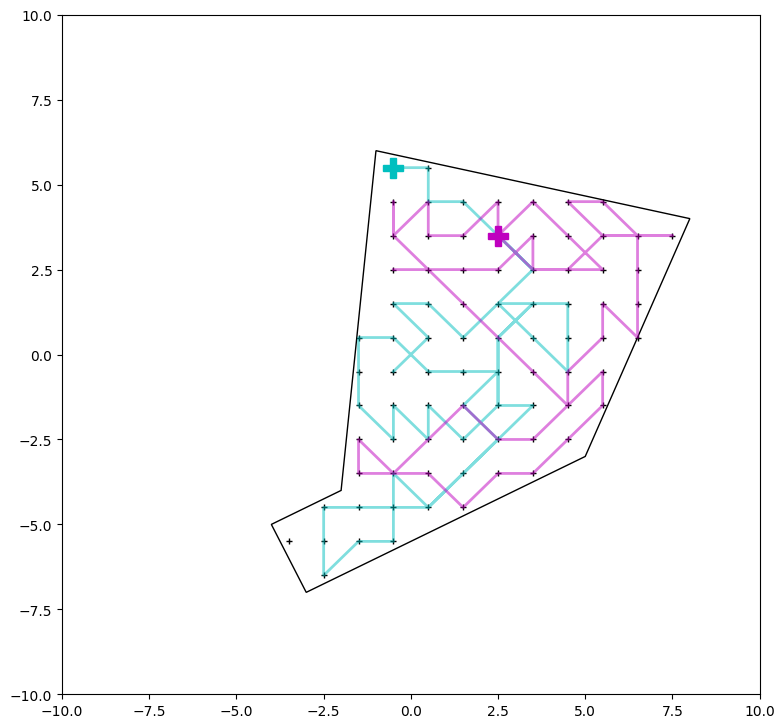

Runtime


In [23]:
showPath(finalGoal)